In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

from tensorflow.keras.preprocessing import image_dataset_from_directory


In [2]:
SIZE = 224
IMG_SIZE = (SIZE, SIZE)
BATCH_SIZE = 32

train_ds = image_dataset_from_directory(
    'resized',
    validation_split=0.3,
    subset="training",
    label_mode='categorical',
    seed=1337,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

validation_ds = image_dataset_from_directory(
    'resized',
    validation_split=0.3,
    subset="validation",
    label_mode='categorical',
    seed=1337,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)


Found 1803 files belonging to 8 classes.
Using 1263 files for training.
Found 1803 files belonging to 8 classes.
Using 540 files for validation.


['1.5', '2.5', '3.5', '4.5', '5.5', 'hb', 'sb', 'x']


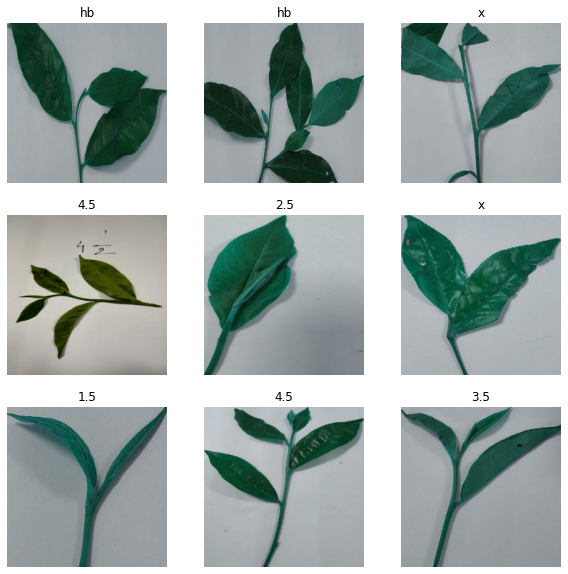

In [52]:
class_names = train_ds.class_names
print(class_names)

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    y = np.argmax(labels[i], axis=-1)
    plt.title(class_names[y])
    plt.axis("off")


In [4]:
val_batches = tf.data.experimental.cardinality(validation_ds)
test_ds = validation_ds.take(val_batches // 3)
validation_ds = validation_ds.skip(val_batches // 3)

In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_ds.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_ds.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_ds.prefetch(buffer_size=AUTOTUNE)


In [6]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

print('Number of train batches: %d' % tf.data.experimental.cardinality(train_ds))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))


Number of train batches: 40
Number of validation batches: 12
Number of test batches: 5


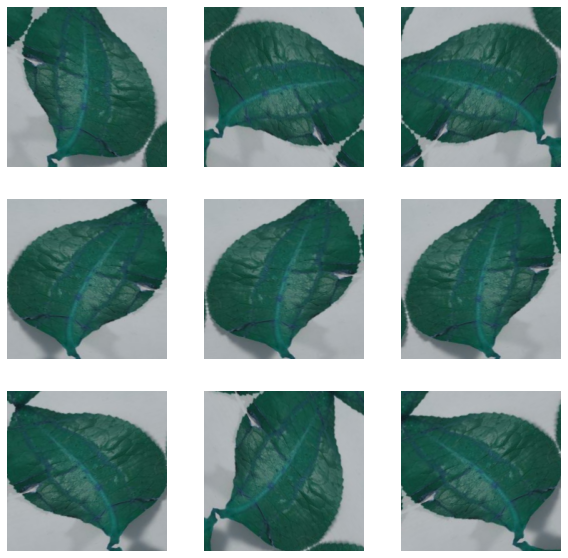

In [7]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')


In [9]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


In [10]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)


(32, 7, 7, 1280)


In [11]:
base_model.trainable = False

In [12]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)


(32, 1280)


In [13]:
prediction_layer = tf.keras.layers.Dense(units=8, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)


(32, 8)


In [14]:
inputs = tf.keras.Input(shape=(SIZE, SIZE, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)
base_model.trainable = False

In [15]:
base_learning_rate = 0.0001
alpha = 0.75

loss1 = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
loss2 = tf.keras.losses.BinaryCrossentropy(from_logits=True)

classes = np.array(class_names)
fine = np.reshape(np.array(np.logical_or(
            np.logical_or(classes == '1.5', classes == '2.5'),
            classes == 'sb'
        ), dtype=np.float32), (8, 1))

def loss(y1, y2):
    y3, y4 = np.matmul(y1, fine), np.matmul(y2, fine)
    l1 = loss1(y1, y2)
    l2 = loss2(y3, y4)
    # print (l1, l2)
    return l1 + l2 * alpha

model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=loss,
              metrics=['accuracy'],
              run_eagerly=True)
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [23]:
len(model.trainable_variables)


2

In [17]:
initial_epochs = 100

loss0, accuracy0 = model.evaluate(validation_dataset)


12/12 [==============================] - 1s 51ms/step - loss: 3.0594 - accuracy: 0.0761


In [18]:
initial_epochs = 40
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)


Epoch 1/40
40/40 [==============================] - 7s 167ms/step - loss: 2.7721 - accuracy: 0.1663 - val_loss: 2.5486 - val_accuracy: 0.2237
Epoch 2/40
40/40 [==============================] - 7s 163ms/step - loss: 2.5462 - accuracy: 0.2312 - val_loss: 2.4551 - val_accuracy: 0.2921
Epoch 3/40
40/40 [==============================] - 7s 155ms/step - loss: 2.4139 - accuracy: 0.3088 - val_loss: 2.2884 - val_accuracy: 0.3500
Epoch 4/40
40/40 [==============================] - 7s 165ms/step - loss: 2.3112 - accuracy: 0.3333 - val_loss: 2.2363 - val_accuracy: 0.3895
Epoch 5/40
40/40 [==============================] - 7s 156ms/step - loss: 2.2218 - accuracy: 0.3713 - val_loss: 2.1513 - val_accuracy: 0.4447
Epoch 6/40
40/40 [==============================] - 7s 154ms/step - loss: 2.1639 - accuracy: 0.3911 - val_loss: 2.0689 - val_accuracy: 0.4684
Epoch 7/40
40/40 [==============================] - 7s 159ms/step - loss: 2.0364 - accuracy: 0.4473 - val_loss: 1.9907 - val_accuracy: 0.5053
Epoch 

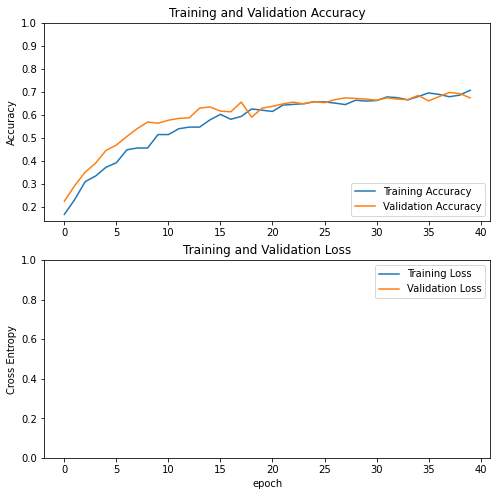

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [43]:
x = None
y_act = np.array([],dtype=np.int)
y_pred = np.array([],dtype=np.int)
for image_batch, label_batch in test_dataset.as_numpy_iterator():
    predictions = model.predict(image_batch)
    x = np.concatenate((image_batch, x)) if x is not None else image_batch
    y_act = np.concatenate((label_batch.argmax(axis=1), y_act))
    y_pred = np.concatenate((predictions.argmax(axis=1), y_pred))

matrix = tf.math.confusion_matrix(labels=y_act, predictions=y_pred)
print(matrix, sum(sum(matrix)))
print(x.shape)


tf.Tensor(
[[19  2  0  0  0  0  0  1]
 [ 0 27  1  0  0  0  1  0]
 [ 0  2 13  1  0  0  0  0]
 [ 0  0  0 27  0  0  0  0]
 [ 0  0  0  2  7  0  0  0]
 [ 0  0  2  4  0 16  0  2]
 [ 0  4  2  1  0  1 13  1]
 [ 0  0  0  0  0  1  0 10]], shape=(8, 8), dtype=int32) tf.Tensor(160, shape=(), dtype=int32)
(160, 224, 224, 3)


9 160
28
hb, 4.5 -> 4
sb, 2.5 -> 4
1.5, 2.5 -> 2
3.5, 2.5 -> 2
5.5, 4.5 -> 2
hb, 3.5 -> 2
hb, x -> 2
sb, 3.5 -> 2
1.5, x -> 1
2.5, 3.5 -> 1
2.5, sb -> 1
3.5, 4.5 -> 1
sb, 4.5 -> 1
sb, hb -> 1
sb, x -> 1
x, hb -> 1


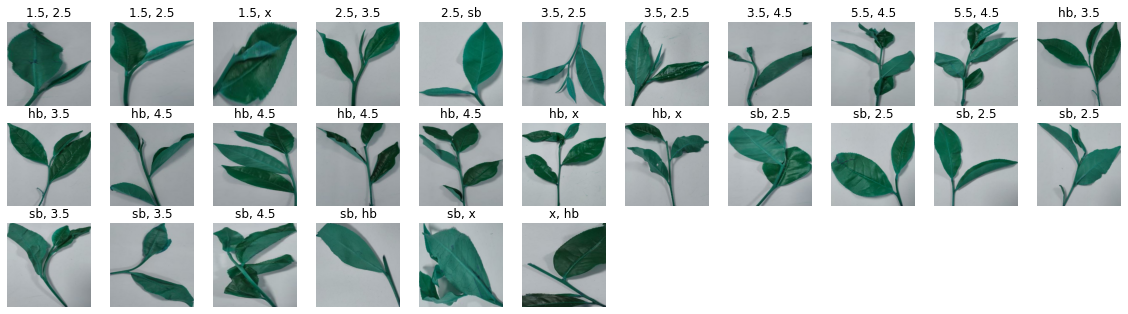

In [44]:
def wrong(actual, predicted):
    A = np.array(class_names)[y_act] == actual
    B = np.array(class_names)[y_pred] == predicted
    index = np.logical_and(A, B)
    total = sum(index)
    
    t_x, t_y, t_pred = x[index], y[index], y_pred[index]
    
    print('Actual: {}, Predicted: {}'.format(actual, predicted))
    
    plt.figure(figsize=(10, 10))
    for i in range(total):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(t_x[i].astype("uint8"))
      plt.axis("off")


t = np.array(class_names)

def is_fine(a):
    return np.logical_or(
            np.logical_or(t[a] == '1.5', t[a] == '2.5'),
            t[a] == 'sb'
        )


result = is_fine(y_act) != is_fine(y_pred)
print(sum(result), len(result))

index = y_act != y_pred
# index = result
t_x, t_y, t_pred = x[index], y_act[index], y_pred[index]
total = sum(index)
print(total)
plt.figure(figsize=(20, 20))

samples = []


for i in range(total):
    actual = t[t_y[i]]
    predicted = t[t_pred[i]]
    samples.append(('{}, {}'.format(actual, predicted), t_x[i]))

samples.sort(key=lambda a: a[0])
count = {}

for i, sample in enumerate(samples):
    ax = plt.subplot(11, 11, i + 1)
    plt.title(sample[0])
    count[sample[0]] = count.get(sample[0], 0) + 1
    plt.imshow(sample[1].astype("uint8"))
    plt.axis("off")

items = list(count.items())
items.sort(key=lambda a: -a[1])
for item in items:
    print(item[0], '->', item[1])

In [24]:
base_model.trainable = True


In [38]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 80

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

for layer in base_model.layers[fine_tune_at:]:
  layer.trainable = True


Number of layers in the base model:  154


In [39]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])
len(model.trainable_variables)


77

In [41]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)


Epoch 40/45
40/40 [==============================] - 4s 86ms/step - loss: 0.2899 - accuracy: 0.8987 - val_loss: 0.6129 - val_accuracy: 0.7921
Epoch 41/45
40/40 [==============================] - 4s 87ms/step - loss: 0.3026 - accuracy: 0.8947 - val_loss: 0.5401 - val_accuracy: 0.8237
Epoch 42/45
40/40 [==============================] - 3s 78ms/step - loss: 0.2943 - accuracy: 0.8971 - val_loss: 0.5950 - val_accuracy: 0.7789
Epoch 43/45
40/40 [==============================] - 4s 80ms/step - loss: 0.2944 - accuracy: 0.8947 - val_loss: 0.5190 - val_accuracy: 0.8026
Epoch 44/45
40/40 [==============================] - 4s 80ms/step - loss: 0.2696 - accuracy: 0.8994 - val_loss: 0.4922 - val_accuracy: 0.8342
Epoch 45/45
40/40 [==============================] - 4s 85ms/step - loss: 0.2637 - accuracy: 0.9113 - val_loss: 0.5260 - val_accuracy: 0.8342


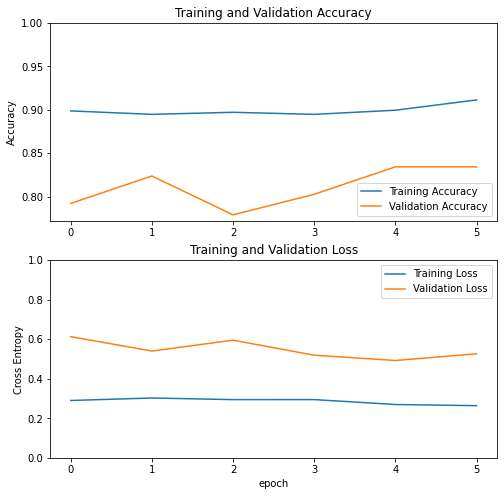

In [42]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [69]:
model2 = tf.keras.Model(inputs=model.input, outputs=model.get_layer('dropout_2').input)
model2.summary()

def make_embeddings(dataset):
    embeddings = []
    labels = []
    data = []

    for image_batch, label_batch in dataset.as_numpy_iterator():
        pred = model2.predict(image_batch)
        # print (pred.shape,  np.linalg.norm(pred, axis=1).shape)
        pred = (pred.T / np.linalg.norm(pred, axis=1)).T
#         print (np.linalg.norm(pred, axis=1).shape, pred.shape)
#         print( list(pred[0]))
#         break
        embeddings.append(pred)
        labels.append(label_batch.argmax(axis=1))
        data.append(image_batch)
    

    return np.concatenate(embeddings, axis=0), np.concatenate(labels, axis=0), np.concatenate(data, axis=0)

def nearest1(e, dataset, labels, n=50):
    dist = np.matmul(e, dataset.T)
    match = labels[dist.argsort()][-n:]
    counts = np.bincount(match)
    return np.argmax(counts)


def nearest2(e, dataset, labels):
    dist = np.matmul(e, dataset.T)
    mean_dist = np.array([np.mean(dist[labels == l]) for l in range(len(class_names))])
    return (mean_dist.argmax())

# train_embeddings, train_labels = make_embeddings(train_dataset)
# validation_embeddings, validation_labels = make_embeddings(validation_dataset)
# test_embeddings, test_labels = make_embeddings(test_dataset)

# make_embeddings(test_dataset)


Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_2 (Sequential)    (None, None, None, 3)     0         
_________________________________________________________________
tf.math.truediv_2 (TFOpLambd (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract_2 (TFOpLamb (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
Total params: 2,257,984
Trainable params: 1,861,440
Non-trainable params: 396,544
___________________________________________

In [74]:
def analyze(test_ds, train_ds):
    train_e, train_l, train_x = make_embeddings(train_ds)
    test_e, test_l, test_x = make_embeddings(test_ds)

    actual = []
    predicted1 = []
    predicted2 = []
    for i, d in enumerate(test_e):
        actual.append(test_l[i])
        predicted1.append(nearest1(test_e[i], train_e, train_l, n=1))
        predicted2.append(nearest2(test_e[i], train_e, train_l))
    matrix1 = tf.math.confusion_matrix(labels=actual, predictions=predicted1)
    matrix2 = tf.math.confusion_matrix(labels=actual, predictions=predicted2)
    print('Accuracy: {}, {}'.format(
        np.mean(np.array(actual) == np.array(predicted1)),
        np.mean(np.array(actual) == np.array(predicted2))
    ))
    print('Accuracy: {}, {}'.format(
        np.mean(is_fine(actual) == is_fine(predicted1)),
        np.mean(is_fine(actual) == is_fine(predicted2))
    ))
    print(matrix1, matrix2)

analyze(train_dataset, test_dataset)

Accuracy: 0.6666666666666666, 0.6571654790182107
Accuracy: 0.897070467141726, 0.9224069675376089
tf.Tensor(
[[133  29   2   0   0   2  16   0]
 [ 12 184  26   0   0   1  33   1]
 [  7   9 110   6   2   7  13   0]
 [  0   4   6 182  26  16   7   2]
 [  0   0   5  22  44   0   1   0]
 [  3   3  13  11  20  56  10  10]
 [  2  28  13   0   4   8  89   1]
 [  2   3   8   8   4   5  10  44]], shape=(8, 8), dtype=int32) tf.Tensor(
[[ 90  74   1   0   0   0  17   0]
 [  1 217  30   1   0   2   6   0]
 [  0  13 131   2   0   7   1   0]
 [  0   0  15 127  62  37   2   0]
 [  0   0   2   0  68   2   0   0]
 [  0   2  18   3  15  79   7   2]
 [  0  33  20   1   4   7  80   0]
 [  0   3  11   0  23   5   4  38]], shape=(8, 8), dtype=int32)


In [46]:
model.save('/tf/src/model/checkpoint')

INFO:tensorflow:Assets written to: /tf/src/model/checkpoint/assets


In [49]:
print(tf.keras.applications.mobilenet_v2)

<module 'tensorflow.keras.applications.mobilenet_v2' from '/usr/local/lib/python3.6/dist-packages/tensorflow/keras/applications/mobilenet_v2/__init__.py'>


<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3000x4000 at 0x7F9BE873F6A0>


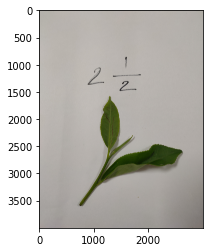

In [51]:
from tensorflow.keras.preprocessing import image
img = image.load_img('data/2.5/IMG20210623132457-weird.jpg')
print(img)
plt.imshow(img)
